In [ ]:
#@title Imports/Installs
import time
import math
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output

In [ ]:
#@title Mount Google Drive
import os
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from tables import filters
#@title Load and Clean Data

# Only take stocks with a continuous searchFrom days. Then, randomly select
# numDays days from each one. This way, the AI doesn't just memorize the
# general market trends for the predicted days as they would align in date otherwise.
searchFrom = 1000 #@param
# Number of stocks to try to use. There are 5589 total.
numStocks = 5589 #@param
# In case the most recent data is outliers
offsetRecent = 50 #@param

# Reads one CSV file given a filename
# Returns the High, Low, and Volume in a numpy array
# Returns an empty array if there isn't enough days of data for the stock
def formatCSV(name):
  df = pd.read_csv(name).drop(columns=['Date', 'Open', 'Close', 'Adj Close'])
  print(name)
  final = df.to_numpy()
  if len(final) < searchFrom + offsetRecent:
    return []
  if np.any(np.isnan(final[-searchFrom - offsetRecent:-offsetRecent])):
    return []
  return final[-searchFrom - offsetRecent:-offsetRecent].astype(np.float64)

# Read all of the CSV files and aggregate the dataset

# Dataset shape may vary as stocks are randomly
# chosen and stocks w/o enough data are removed.
tic = time.perf_counter()
trainPath = '/gdrive/MyDrive/StockInfo/stocks/'
files = os.listdir(trainPath)
np.random.shuffle(files)
trainData = [formatCSV(trainPath + filename) for filename in files]#[:numStocks]]
trainData = [stock for stock in trainData if len(stock) and not np.any(np.isnan(stock))]
trainData = np.array(trainData, dtype=np.float64)
trainData = np.swapaxes(trainData, 1, 2)
clear_output()
print("Dataset Shape:\t", trainData.shape) # Stock, Attribute, Day
toc = time.perf_counter()
print(f'Time: {toc - tic} seconds')


Dataset Shape:	 (4626, 3, 1000)
Time: 251.89421303700001 seconds


In [ ]:
#@title Format Data
def parallelShuffle(a, b):
  shuffler = np.random.permutation(len(a))
  return a[shuffler], b[shuffler]

# Number of days of data to take from each stock
numDays = 400 #@param
# Number of days to predict
predictDays = 5 #@param
# Take 2 samples for each stock
repeat = 3 #@param

oldTrain = trainData.copy()
for n in range(repeat - 1):
  trainData = np.append(trainData, trainData.copy(), 0)
print(trainData.shape)

# Split off each set.
testLabel = trainData[:,:,-predictDays - numDays:].copy()
testFeat = trainData[:,:,-numDays - predictDays:-predictDays].copy()
trainFeat = np.zeros((len(trainData), 3, numDays), dtype=np.float64)
trainLabel = np.zeros((len(trainData), 3, numDays + predictDays), dtype=np.float64)
for x, data in enumerate(trainData):
  offset = random.randint(0, searchFrom - (numDays + (2 * predictDays))) + (2 * predictDays)
  trainFeat[x] = data[:, -offset - numDays:-offset]
  trainLabel[x] = data[:, -offset - numDays:-offset + predictDays]

print(trainFeat.shape)
print(trainLabel.shape)
print(testFeat.shape)
print(testLabel.shape)

# Normalize Data
# Scales each value so that:
#   - For each stock, the maximum "stock high" before cutoff is 1, and the minimum is 0
#   - For each stock, the maximum "stock low" before cutoff is 1, and the minimum is 0
#   - For each stock, the maximum "volume" before cutoff is 1, and the minimum is 0

for x, stock in enumerate(trainFeat):
  #Min/Max Scale the high
  smol = np.min(stock[0])
  large = np.max(stock[0])
  trainFeat[x, 0] = (stock[0] - smol) / (large - smol)
  trainLabel[x, 0] = (trainLabel[x, 0] - smol) / (large - smol)
  #Min/Max Scale the low
  smol = np.min(stock[1])
  large = np.max(stock[1])
  trainFeat[x, 1] = (stock[1] - smol) / (large - smol)
  trainLabel[x, 1] = (trainLabel[x, 1] - smol) / (large - smol)
  #Min/Max Scale the volume
  smol = np.min(stock[2])
  large = np.max(stock[2])
  trainFeat[x, 2] = (stock[2] - smol) / (large - smol)
  trainLabel[x, 2] = (trainLabel[x, 2] - smol) / (large - smol)

notNormTest = np.zeros((len(testFeat), 2)) # (min, range)
for x, stock in enumerate(testFeat):
  #Min/Max Scale the high
  smol = np.min(stock[0])
  large = np.max(stock[0])
  rng = large - smol
  notNormTest[x][0] = smol
  notNormTest[x][1] = rng
  testFeat[x, 0] = (stock[0] - smol) / (rng)
  testLabel[x, 0] = (testLabel[x, 0] - smol) / (rng)
  #Min/Max Scale the low
  smol = np.min(stock[1])
  large = np.max(stock[1])
  testFeat[x, 1] = (stock[1] - smol) / (large - smol)
  testLabel[x, 1] = (testLabel[x, 1] - smol) / (large - smol)
  #Min/Max Scale the volume
  smol = np.min(stock[2])
  large = np.max(stock[2])
  testFeat[x, 2] = (stock[2] - smol) / (large - smol)
  testLabel[x, 2] = (testLabel[x, 2] - smol) / (large - smol)

# Filter outliers
prev = len(trainLabel)
pairs = zip(trainFeat, trainLabel)
pairs = [(feat, data) for feat, data in pairs if (not (np.max(data) > 5 or np.min(data) < -5)) and (not np.any(np.isnan(data)))]
trainFeat = np.array([data for data, _ in pairs])
trainLabel = np.array([data for _, data in pairs])
print("Removed", prev - len(trainLabel), "outliers from train.")

prev = len(testLabel)
pairs = zip(testFeat, testLabel, notNormTest)
pairs = [(feat, data, notNorm) for feat, data, notNorm in pairs if (not (np.max(data) > 5 or np.min(data) < -5)) and (not np.any(np.isnan(data)))]
testFeat = np.array([data for data, _, _ in pairs])
testLabel = np.array([data for _, data, _ in pairs])
notNormTest = np.array([data for _, _, data in pairs])
print("Removed", prev - len(testLabel), "outliers from test.")

# Anti-0 values
trainFeat += 0.0001
trainLabel += 0.0001
testFeat += 0.0001
testLabel += 0.0001

print(trainFeat.shape)
print(trainLabel.shape)
print(testFeat.shape)
print(testLabel.shape)

print("Done")

(18504, 3, 1000)
(18504, 3, 400)
(18504, 3, 405)
(18504, 3, 400)
(18504, 3, 405)


<ipython-input-6-9c2534e6f71a>:43: RuntimeWarning: invalid value encountered in true_divide
  trainFeat[x, 0] = (stock[0] - smol) / (large - smol)
<ipython-input-6-9c2534e6f71a>:44: RuntimeWarning: invalid value encountered in true_divide
  trainLabel[x, 0] = (trainLabel[x, 0] - smol) / (large - smol)
<ipython-input-6-9c2534e6f71a>:48: RuntimeWarning: invalid value encountered in true_divide
  trainFeat[x, 1] = (stock[1] - smol) / (large - smol)
<ipython-input-6-9c2534e6f71a>:49: RuntimeWarning: invalid value encountered in true_divide
  trainLabel[x, 1] = (trainLabel[x, 1] - smol) / (large - smol)
<ipython-input-6-9c2534e6f71a>:53: RuntimeWarning: invalid value encountered in true_divide
  trainFeat[x, 2] = (stock[2] - smol) / (large - smol)
<ipython-input-6-9c2534e6f71a>:54: RuntimeWarning: invalid value encountered in true_divide
  trainLabel[x, 2] = (trainLabel[x, 2] - smol) / (large - smol)


Removed 53 outliers from train.
Removed 40 outliers from test.
(18451, 3, 400)
(18451, 3, 405)
(18464, 3, 400)
(18464, 3, 405)
Done


In [ ]:
assert not np.any(np.isnan(trainData))
assert not np.any(np.isnan(trainFeat))
assert not np.any(np.isnan(testFeat))
assert not np.any(np.isnan(trainLabel))
assert not np.any(np.isnan(testLabel))
assert not np.any(np.isnan(notNormTest))

In [ ]:
#@title Define the GAN
from tensorflow.keras import layers

class GAN(tf.keras.Model):
    def __init__(self, latent_dim, total_dim, channels):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        self.total_dim = total_dim
        self.channels = channels

        # Generator
        # Generates fake data to fool the discriminator

        self.generator = tf.keras.Sequential(
            [
                layers.Input(shape=(self.channels, self.total_dim)),
                layers.Flatten(),
                layers.Dense(6 * self.total_dim, input_dim=self.total_dim * self.channels, input_shape=(self.channels * self.total_dim,)),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(6 * self.total_dim),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(4 * self.total_dim),
                layers.LeakyReLU(alpha=0.2),
                #layers.Reshape((3, self.total_dim))
                layers.Reshape((1, 4 * self.total_dim)),
                layers.Conv1DTranspose(self.total_dim, 5, strides=3, padding='same'),
                layers.LeakyReLU(alpha=0.2)
            ]
        )

        # Discriminator
        # Takes in a stock graph and outputs 0 for fake and 1 for real.

        self.discriminator = tf.keras.Sequential(
            [
                layers.Conv1D(256, 10, strides=5, padding='same', data_format="channels_first"),
                layers.LeakyReLU(alpha=0.2),
                #layers.Dropout(0.1),
                layers.Conv1D(256, 5, strides=3, padding='same', data_format="channels_first"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv1D(128, 5, strides=2, padding='same', data_format="channels_first"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv1D(128, 3, strides=1, padding='same', data_format="channels_first"),
                layers.LeakyReLU(alpha=0.2),
                layers.Flatten(),
                layers.Dense(1500, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(1500, activation='relu'),
                layers.Dense(1, activation='sigmoid')
            ]
        )


    def compile(self, d_optimizer, g_optimizer, loss_fn, loss2):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.loss2 = loss2

    def call(self, input):
        random_latent_vectors = tf.random.normal(shape=(input.shape[0], self.channels, self.latent_dim))
        input_vectors = tf.concat([input, random_latent_vectors], axis=-1)
        fake = self.generator(input_vectors)
        output = self.discriminator(fake)
        return fake, output

    def train_step(self, conditions, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.channels, self.latent_dim))
        input_vectors = np.append(conditions, random_latent_vectors, -1)

        # Train the discriminator
        with tf.GradientTape() as tape:
            fake_images = self.generator(input_vectors)
            predicted = tf.slice(fake_images, begin=[0, 0, self.total_dim - self.latent_dim], size=[batch_size, self.channels, self.latent_dim])
            continued_images = tf.concat([conditions, predicted], axis = -1)
            combined_images = tf.concat([continued_images, real_images], axis=0)
            labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train the generator
        with tf.GradientTape(persistent=True) as tape:
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.channels, self.latent_dim))
            input_vectors = np.append(conditions, random_latent_vectors, -1)
            fake_images = self.generator(input_vectors)
            predicted = tf.slice(fake_images, begin=[0, 0, self.total_dim - self.latent_dim], size=[batch_size, self.channels, self.latent_dim])
            given = tf.slice(fake_images, begin=[0, 0, 0], size=[batch_size, self.channels, self.total_dim - self.latent_dim])
            continued_images = tf.concat([conditions, predicted], axis = -1)
            labels = tf.ones((batch_size, 1))
            predictions = self.discriminator(continued_images)
            g_loss = self.loss_fn(labels, predictions)
            g_mean_loss = self.loss2(conditions, given)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        grads2 = tape.gradient(g_mean_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.g_optimizer.apply_gradients(zip(grads2, self.generator.trainable_weights))
        del tape

        return {'d_loss': d_loss, 'g_loss': g_loss, 'g_mean_loss': g_mean_loss}

model = GAN(predictDays, numDays + predictDays, 3)
model.build((1, 3, numDays))
model.generator.summary()
model.discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1215)              0         
                                                                 
 dense (Dense)               (None, 2430)              2954880   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2430)              0         
                                                                 
 dense_1 (Dense)             (None, 2430)              5907330   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2430)              0         
                                                                 
 dense_2 (Dense)             (None, 1620)              3938220   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1620)              0

In [ ]:
#@title Train the model

preserve = False #@param{type:'boolean'}
epochs = 32
batchSize = 32

if not preserve:
  model = GAN(latent_dim=predictDays, total_dim=numDays + predictDays, channels=3)
  model.compile(
      d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
      g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
      loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      loss2=tf.keras.losses.MeanSquaredError()
  )
  problem = []
  hist = []

for epoch in range(epochs):
  print("\tEpoch: ", epoch)
  for batch in range(0, len(trainFeat), batchSize):
    if (batch / batchSize) % 50 == 0:
      print((batch / batchSize), " / ", len(trainFeat) / batchSize)
    hist.append(model.train_step(trainFeat[batch:batch + batchSize], trainLabel[batch:batch + batchSize]))
    if hist[-1]['g_loss'] > 5:
      problem = batch
  trainFeat, trainLabel = parallelShuffle(trainFeat, trainLabel)

fake, guess = model.call(trainFeat[0:1])
print(fake.shape)
plt.plot(fake[0, 0], label='fake')
plt.plot(trainLabel[0, 0], label='real')
plt.axvline(numDays, color='r')
print(guess[0])

	Epoch:  0
0.0  /  576.59375


50.0  /  576.59375
100.0  /  576.59375
150.0  /  576.59375
200.0  /  576.59375
250.0  /  576.59375
300.0  /  576.59375
350.0  /  576.59375
400.0  /  576.59375
450.0  /  576.59375
500.0  /  576.59375
550.0  /  576.59375
	Epoch:  1
0.0  /  576.59375
50.0  /  576.59375
100.0  /  576.59375
150.0  /  576.59375
200.0  /  576.59375
250.0  /  576.59375
300.0  /  576.59375
350.0  /  576.59375
400.0  /  576.59375
450.0  /  576.59375
500.0  /  576.59375
550.0  /  576.59375
	Epoch:  2
0.0  /  576.59375
50.0  /  576.59375
100.0  /  576.59375
150.0  /  576.59375
200.0  /  576.59375
250.0  /  576.59375
300.0  /  576.59375
350.0  /  576.59375
400.0  /  576.59375
450.0  /  576.59375
500.0  /  576.59375
550.0  /  576.59375
	Epoch:  3
0.0  /  576.59375
50.0  /  576.59375
100.0  /  576.59375
150.0  /  576.59375
200.0  /  576.59375
250.0  /  576.59375
300.0  /  576.59375
350.0  /  576.59375
400.0  /  576.59375
450.0  /  576.59375
500.0  /  576.59375
550.0  /  576.59375
	Epoch:  4
0.0  /  576.59375
50.0  / 

KeyboardInterrupt: ignored

{'d_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6919786>, 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6469636>, 'g_mean_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0023890187>}


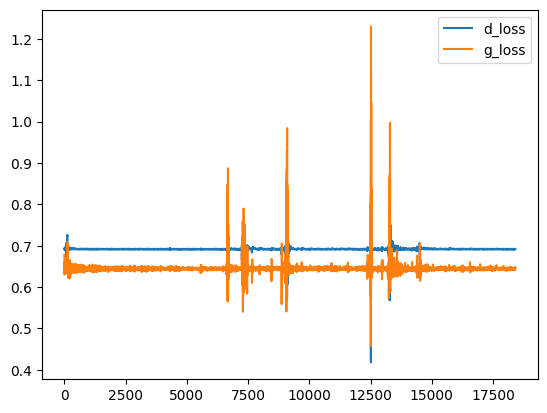

In [ ]:
#@title Plot loss
plt.plot([x['d_loss'] for x in hist], label='d_loss')
plt.plot([x['g_loss'] for x in hist], label='g_loss')
plt.legend()
print(hist[-1])

In [ ]:
sample = 0

Train:  tf.Tensor([0.5236571], shape=(1,), dtype=float32)
Test:  tf.Tensor([0.5235517], shape=(1,), dtype=float32)


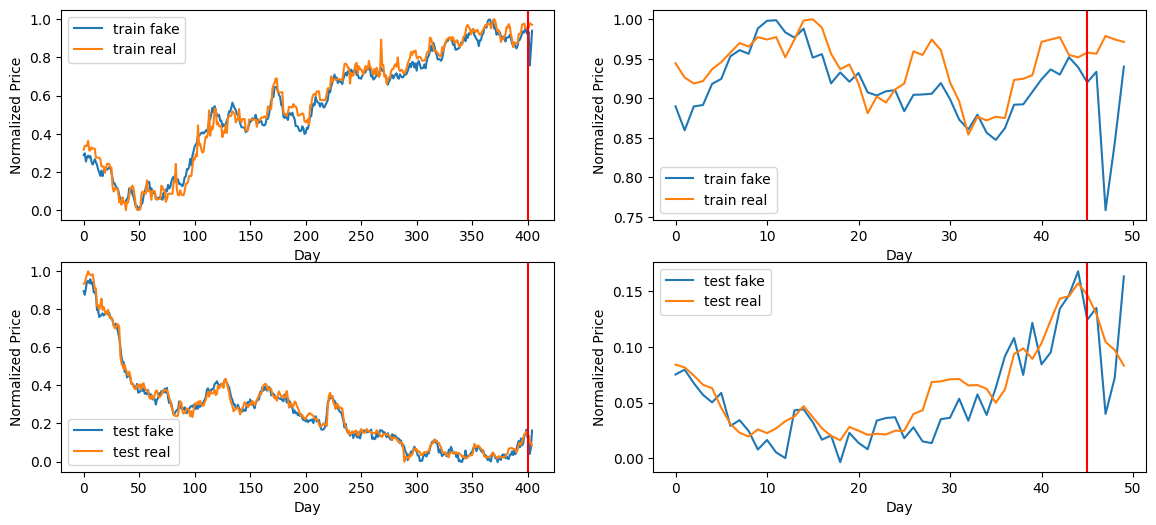

In [ ]:
#@title Eval on train/test
f, axarr = plt.subplots(2,2, figsize=(14,6))
aspect = 0
zoom = 50
fake, guess = model.call(trainFeat[sample + 1:sample + 2])
print("Train: ", guess[0])
axarr[0][0].plot(fake[0][aspect], label='train fake')
axarr[0][0].plot(trainLabel[sample + 1][aspect], label='train real')
axarr[0][0].axvline(numDays, color='r')
axarr[0][0].set_xlabel('Day')
axarr[0][0].set_ylabel('Normalized Price')
axarr[0][0].legend()
axarr[0][1].plot(fake[0][aspect][-zoom:], label='train fake')
axarr[0][1].plot(trainLabel[sample + 1][aspect][-zoom:], label='train real')
axarr[0][1].axvline(zoom - predictDays, color='r')
axarr[0][1].set_xlabel('Day')
axarr[0][1].set_ylabel('Normalized Price')
axarr[0][1].legend()
fake, guess = model.call(testFeat[sample:sample + 1])
axarr[1][0].plot(fake[0][aspect], label='test fake')
axarr[1][0].plot(testLabel[sample][aspect], label='test real')
axarr[1][0].axvline(numDays, color='r')
axarr[1][0].set_xlabel('Day')
axarr[1][0].set_ylabel('Normalized Price')
axarr[1][0].legend()
axarr[1][1].plot(fake[0][aspect][-zoom:], label='test fake')
axarr[1][1].plot(testLabel[sample][aspect][-zoom:], label='test real')
axarr[1][1].axvline(zoom - predictDays, color='r')
axarr[1][1].set_xlabel('Day')
axarr[1][1].set_ylabel('Normalized Price')
axarr[1][1].legend()
print("Test: ", guess[0])
plt.show()
plt.close()
sample += 1

In [ ]:
#@title Eval on test set
# testOffset = (min, range)

def getGain(latest, close, mini, rng):
  latest = latest * rng + mini
  close = close * rng + mini
  return (close - latest) / latest

lng = 0
avg = 0
mse = 0
std = 0
err = 0
pct = 0
for x in range(len(testFeat)):
  _, outputs = model.call(np.array([testFeat[x] for _ in range(5)]))
  avgPred = np.mean(outputs[:][0][-predictDays:], 0)
  basic = testLabel[x][0][-predictDays:] - avgPred
  mse += (basic) ** 2
  err += np.abs(basic)
  pct += np.abs(basic / testLabel[x][0][-predictDays:])
  simple = np.max(avgPred) # Take the maximum value from the average prediction
  latest = testLabel[x][0][-predictDays - 1] # Most recent day
  # If the maximum predicted is below the most recent day, short the stock, otherwise go long.
  if simple < latest:
    # short
    close = testLabel[x][0][-1]
    if close != latest:
      gain = getGain(latest, close, notNormTest[x][0], notNormTest[x][1])
      avg += -1 * gain
      std += gain
    else:
      print("handled")
  else:
    # buy
    lng += 1
    flag = True
    for i in range(predictDays):
      if testLabel[x][0][numDays + i] >= simple:
        close = testLabel[x][0][numDays + i]
        if close != latest:
          avg += getGain(latest, close, notNormTest[x][0], notNormTest[x][1])
          std += getGain(latest, testLabel[x][0][-1], notNormTest[x][0], notNormTest[x][1])
        else:
          print("handled")
        flag = False
        break
    if flag:
      close = testLabel[x][0][-1]
      if close != latest:
        gain = getGain(latest, close, notNormTest[x][0], notNormTest[x][1])
        avg += gain
        std += gain
      else:
        print("handled")
print((len(testFeat) - lng), "short positions, ", lng, "long positions.")
print("Average gain:\t", (avg / len(testFeat)) * 100)
print("Stock whole gain:\t", (std / len(testFeat)) * 100)
print()
print("Mean Squared Error:\t", np.sum(mse) / len(testFeat))
print("RMSE:\t", math.sqrt(np.sum(mse) / len(testFeat)))
print("MAE: \t", np.sum(err) / len(testFeat))
print("MAPE: \t", np.sum(pct) / len(testFeat))


handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled
handled


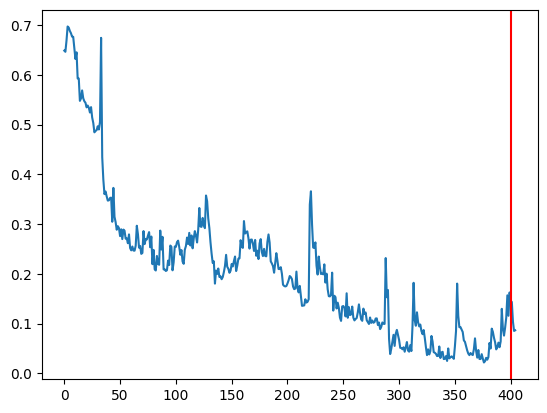

In [ ]:
plt.plot(np.mean(testLabel[:][0][-predictDays:], 0))
plt.axvline(numDays, color='r')

Removed dense layers - 20.33